In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
%matplotlib inline

/home/ravelantunes/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
img_shape = (720, 1280)

In [3]:
# Get camera calibration parameters
def calibration():
    objpoints = []
    imgpoints = []
    
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    for fname in images:    
        img = mpimg.imread(fname)        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)        
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        else:
            print('No grid found for {}'.format(fname))
        
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibration()

No grid found for ./camera_cal/calibration4.jpg
No grid found for ./camera_cal/calibration1.jpg
No grid found for ./camera_cal/calibration5.jpg


In [4]:
def load_test_images():
    images = glob.glob('./test_images/test*.jpg')    

In [5]:
'''
Draw boxes on an image base on a list of tuple pairs
'''
def draw_boxes(img, boxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for box in boxes:
        draw_img = cv2.rectangle(draw_img, box[0], box[1], color, thick)    
    return draw_img

In [6]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # Set defaults if start or end positions are null
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1] - xy_window[0]
        
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    
    if y_start_stop[1] is None:        
        y_start_stop[1] = img.shape[0] - xy_window[1]
    
    current_y = y_start_stop[0]
    
    # Initialize a list to append window positions to
    window_list = []    
    
    while current_y < y_start_stop[1]:
        current_x = x_start_stop[0]        
        while current_x < x_start_stop[1]:        
            window = ((current_x, current_y), (current_x + xy_window[0], current_y + xy_window[1]))
            window_list.append(window)
            # Increment window x
            current_x += np.int(xy_window[0] * xy_overlap[0])
            
        # Increment window y
        current_y += np.int(xy_window[1] * xy_overlap[1])
 
    # Return the list of windows
    return window_list

In [7]:
'''
Helper function to draw bxes on images
'''
def print_image(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.show()

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [10]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [11]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [499]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, is_file_path=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        if is_file_path:
            # Read in each one by one
            image = mpimg.imread(file)
        else:
            image = file
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [500]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [23]:
# Load training dataset
car_images = glob.glob('training_data/*/*/*.png')
cars = []
notcars = []
for image in car_images:
    if 'not_cars' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(car_images))

17760


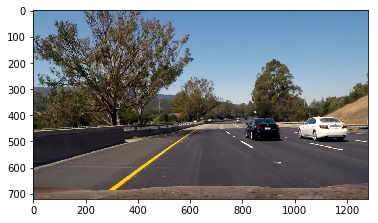

Using 7 windows


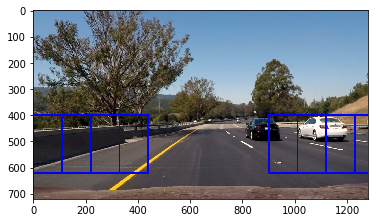

In [489]:
img = mpimg.imread('./test_images/test6.jpg')  
print_image(img)

windows = []
# windows.extend(slide_window(img, x_start_stop=[50, 1500], y_start_stop=[400, 670], 
#                     xy_window=(270, 270), xy_overlap=(0.5, 0.5)))
windows.extend(slide_window(img, x_start_stop=[0, 500], y_start_stop=[400, 620], 
                    xy_window=(220, 220), xy_overlap=(0.5, 0.5)))
windows.extend(slide_window(img, x_start_stop=[900, 1500], y_start_stop=[400, 620], 
                    xy_window=(220, 220), xy_overlap=(0.5, 0.5)))

# windows.extend(slide_window(img, x_start_stop=[0, 1400], y_start_stop=[400, 660], 
#                     xy_window=(180, 180), xy_overlap=(0.5, 0.5)))
# windows.extend(slide_window(img, x_start_stop=[0, 1330], y_start_stop=[370, 600], 
#                     xy_window=(160, 160), xy_overlap=(0.5, 0.6)))
# windows.extend(slide_window(img, x_start_stop=[0, 1330], y_start_stop=[380, 530], 
#                     xy_window=(130, 130), xy_overlap=(0.5, 0.5)))
# windows.extend(slide_window(img, x_start_stop=[0, 1330], y_start_stop=[380, 500], 
#                     xy_window=(100, 100), xy_overlap=(0.5, 0.5)))
# windows.extend(slide_window(img, x_start_stop=[0, 1330], y_start_stop=[350, 530], 
#                     xy_window=(80, 80), xy_overlap=(0.5, 0.5)))


print("Using {} windows".format(len(windows)))
window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

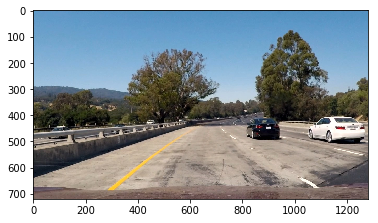

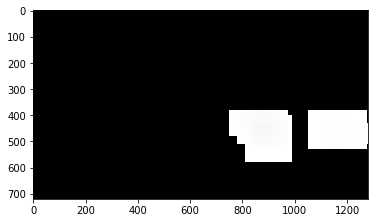

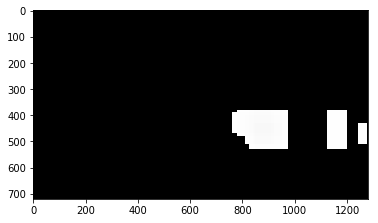

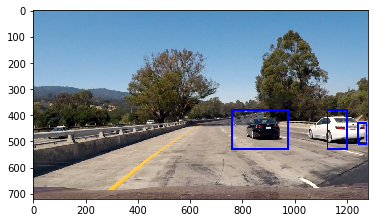

In [259]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
       # Define blocks and steps as above
    nxblocks = (img.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (img.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = pix_per_cell*cell_per_block
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
#     hog_features, vis = get_hog_features(img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)   

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

img = mpimg.imread('test_images/test1.jpg')
t = process_video(img, please_print=True)

In [501]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 5 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 128    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# (9 orient, 9pix per cell, 5 cell per block)
# Channel H (HSV) only: 0.9611
# Channel S (HSV) only: 0.9544
# Channel V (HSV) only: 0.9842

# Spat 32x32 only: 0.9837 (3072)
# Spat 16x16 only: 0.9876 (768)
# Spat 8x8 only: 0.9823 (192)
# Spat 4x4 only: 0.962 (48)

# Color hist 256 bin: 0.9718 (768f)
# Color hist 128 bin: 0.9716 (384f)
# Color hist 64 bin: 0.9648 (192f)
# Color hist 32 bin: 0.9451 (96f)
# Color hist 16 bin: 0.9451 (48f)
# Color hist 8 bin: 0.9448 (24f)

In [502]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [503]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# svc = LinearSVC()
from sklearn import svm
clf = svm.SVC()
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 5 cells per block
Feature vector length: 4176
119.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9966


In [363]:
# Save classifier
import pickle
f = open('n.pickle', 'wb')
pickle.dump(clf, f)
f.close()

In [485]:
with open('solid.pickle', 'rb') as f:
    clf = pickle.load(f) 
#     pass
    


In [79]:
def add_heat(heatmap, detected_windows):    
    for box in detected_windows:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

In [94]:
def apply_threshold(heatmap, threshold=0.5):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [99]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, heatmap):
    
    labels = label(heatmap)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1.0), 6)
    # Return the image
    return img

In [492]:
img = mpimg.imread('test_images/test4.jpg')
img = img.astype(np.float32)/255
# img = mpimg.imread('training_data/cars/GTI_Far/image0000.png')
hot_windows = search_windows(img, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     
print(len(hot_windows))
drawn = np.copy(img)
for window in hot_windows:
    drawn = cv2.rectangle(drawn, window[0], window[1], (0,1.0,0), 6)    
#     hot = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
print_image(drawn)

heatmap = np.zeros_like(img)
heatmap = add_heat(heatmap, hot_windows)
# print_image(heatmap)

thresholded_heatmap = apply_threshold(heatmap, threshold=1)
# print_image(thresholded_heatmap)

labeled = draw_labeled_bboxes(img, heatmap)
print_image(labeled)

ValueError: operands could not be broadcast together with shapes (1,4176) (576,) (1,4176) 

In [483]:
def process_video(img, please_print=False):    
    global previous_heatmap
    img = img.astype(np.float32)/255
    if please_print:
        print_image(img)
    
    hot_windows = search_windows(img, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)     
        
#     previous_heatmap = np.zeros_like(img)
    heatmap = previous_heatmap * 0.5
    if hot_windows is not None:
        heatmap = add_heat(heatmap, hot_windows)
    previous_heatmap = heatmap
    
    if please_print:
        print_image(heatmap)

    thresholded_heatmap = apply_threshold(heatmap, threshold=4)
    
    if please_print:
        print_image(thresholded_heatmap)

    img = draw_labeled_bboxes(img, heatmap)
    
    if please_print:
        print_image(img)
    return img * 255

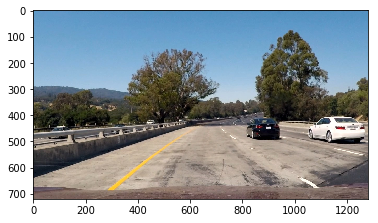

Using 160 windows


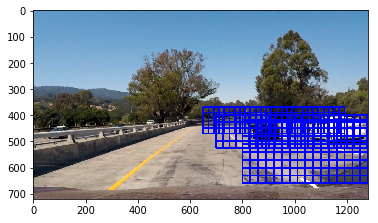

In [481]:
img = mpimg.imread('./test_images/test1.jpg')  
print_image(img)

windows = []
# windows.extend(slide_window(img, x_start_stop=[50, 1500], y_start_stop=[400, 670], 
#                     xy_window=(270, 270), xy_overlap=(0.5, 0.5)))

# windows.extend(slide_window(img, x_start_stop=[0, 500], y_start_stop=[400, 620], 
#                     xy_window=(220, 220), xy_overlap=(0.5, 0.5))) #Left
# windows.extend(slide_window(img, x_start_stop=[900, 1500], y_start_stop=[400, 620], 
#                     xy_window=(220, 220), xy_overlap=(0.5, 0.5))) #Right

# windows.extend(slide_window(img, x_start_stop=[800, 1400], y_start_stop=[400, 660], 
#                     xy_window=(180, 180), xy_overlap=(0.5, 0.5)))
# windows.extend(slide_window(img, x_start_stop=[750, 1330], y_start_stop=[370, 600], 
#                     xy_window=(160, 160), xy_overlap=(0.5, 0.6)))

# windows.extend(slide_window(img, x_start_stop=[700, 1300], y_start_stop=[380, 530], 
#                     xy_window=(130, 130), xy_overlap=(0.5, 0.5)))
windows.extend(slide_window(img, x_start_stop=[650, 1200], y_start_stop=[370, 480], 
                    xy_window=(80, 80), xy_overlap=(0.75, 0.75)))
windows.extend(slide_window(img, x_start_stop=[700, 1300], y_start_stop=[400, 530], 
                    xy_window=(100, 100), xy_overlap=(0.75, 0.75)))
windows.extend(slide_window(img, x_start_stop=[800, 1330], y_start_stop=[420, 680], 
                    xy_window=(120, 120), xy_overlap=(0.75, 0.75)))



print("Using {} windows".format(len(windows)))
window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [482]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lines = []

previous_heatmap = np.zeros_like(img)

output_video = 'output.mp4'
# clip1 = VideoFileClip("test_video.mp4")
# clip1 = VideoFileClip("test_video2.mp4")
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [05:55<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 5min 53s, sys: 1.3 s, total: 5min 54s
Wall time: 5min 55s
